In [32]:
import os
import sys
sys.path.insert(1,os.path.abspath('../Git_Projects/0. Not_git/Sources/scikit-learn/0.23.2'))
import sklearn
print(sklearn.__version__)

0.23.2


### Import libraries

In [33]:
import pandas as pd
import plotly.express as px

from pycaret.regression import *

import plotly.io as pio

In [34]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [35]:
# Select country in analysys ('FIN', 'DEN', 'NOR', 'SWE')
country = 'FIN'

steps = 24  # Number of months of testing

### Load Data

In [36]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Dependant variable
dep_var = 'Orders' 

# Set index
df = df.set_index("Date").asfreq('MS')

In [37]:
df.head()

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,1124,0.807265,8.3,3.28,20178
2006-02-01,1079,0.901804,8.0,3.44,12846
2006-03-01,1210,0.899101,7.7,3.62,15165
2006-04-01,1147,1.297405,7.7,3.88,13474
2006-05-01,1001,1.701702,7.9,3.94,16516


### Split Data

In [38]:
# Split data
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=180)
Test dates     : 2021-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=24)


(Timestamp('2006-01-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'))

### Pycaret

#### Initialize

In [39]:
# Initialize setup
s = setup(    
    data = train, 
    test_data = test, 
    target = dep_var, 
    preprocess=True,  
    fold_strategy = 'timeseries', 
    transform_target = False, 
    data_split_shuffle=False,
    session_id = 42)

,Description,Value
0,session_id,42
1,Target,Orders
2,Original Data,"(180, 5)"
3,Missing Values,0
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(180, 4)"


In [40]:
# Review the transformed dataset
prep_pipe = get_config('prep_pipe') 
transformed_df = prep_pipe.transform(df) 

In [41]:
transformed_df

,CPI,UR,LTIR,TIV
Date,,,,
2006-01-01,0.807265,8.3,3.280000,20178.0
2006-02-01,0.901804,8.0,3.440000,12846.0
2006-03-01,0.899101,7.7,3.620000,15165.0
2006-04-01,1.297405,7.7,3.880000,13474.0
2006-05-01,1.701702,7.9,3.940000,16516.0
...,...,...,...,...
2022-08-01,7.616082,7.2,1.624904,8055.0
2022-09-01,8.119296,7.3,2.420836,7779.0
2022-10-01,8.310766,6.4,2.894486,7026.0


In [42]:
transformed_df.columns

Index(['CPI', 'UR', 'LTIR', 'TIV'], dtype='object')

In [43]:
df.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV'], dtype='object')

#### Model comparison

In [46]:
# Train and evaluate models
exclude_list = ['dummy', 'br', 'knn', 'en', 'omp', 'huber', 'ridge', 'llar', 'lasso', 'lr', 'lar','par']
#exclude_list = []
best = compare_models(exclude = exclude_list, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,132.2672,27757.4738,157.0417,-0.2681,0.3034,0.3160,0.0070
omp,Orthogonal Matching Pursuit,138.8857,33048.6505,164.7517,-0.3554,0.3350,0.3221,0.0070
knn,K Neighbors Regressor,140.5038,33160.7298,170.4036,-0.4664,0.3286,0.3462,0.0120
en,Elastic Net,143.1369,35480.6702,170.5648,-0.7750,0.3320,0.3591,0.0080
ridge,Ridge Regression,154.6867,45154.9894,182.1825,-1.1308,0.3404,0.3738,0.0070
ada,AdaBoost Regressor,160.1458,43941.5212,196.8843,-1.0274,0.3768,0.4184,0.0170
rf,Random Forest Regressor,163.1906,47078.8135,199.5457,-1.1554,0.3696,0.4221,0.0500
llar,Lasso Least Angle Regression,164.0048,51553.4154,192.6122,-1.2628,0.4196,0.3856,0.0090
lasso,Lasso Regression,167.1695,54904.8523,198.1566,-1.3263,0.3888,0.3870,0.4110
par,Passive Aggressive Regressor,167.9295,42990.9464,196.3421,-0.8766,0.3606,0.3257,0.0070


#### Create best model

In [45]:
# Create model
model = create_model(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:06:28
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


#### Tune model

In [ ]:
# Tune model
tuned_model = tune_model(model, n_iter=50, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,235.4500,91700.0471,302.8202,-0.5796,0.7927,1.0961
1,348.6500,134075.0600,366.1626,-5.0733,0.7221,1.0251
2,84.9964,16124.0310,126.9804,0.1981,0.1671,0.1336
3,101.5011,21254.2950,145.7885,0.6355,0.1863,0.1381
4,127.6432,33071.6218,181.8560,-1.1575,0.2828,0.2381
5,103.4118,24230.5014,155.6615,0.0386,0.2508,0.1806
6,138.7205,28814.4885,169.7483,-0.3711,0.2397,0.2115
7,106.9876,16588.3578,128.7958,-0.2059,0.1986,0.1760
8,150.3788,27861.0190,166.9162,0.1080,0.2848,0.2976


In [ ]:
tuned_model

AdaBoostRegressor(base_estimator=None, learning_rate=0.2, loss='exponential',
                  n_estimators=160, random_state=42)

In [ ]:
model

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

#### Plot model

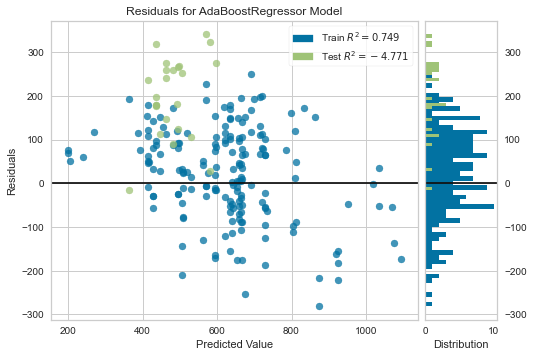

In [ ]:
# PLot model - Residual plot
plot_model(model)

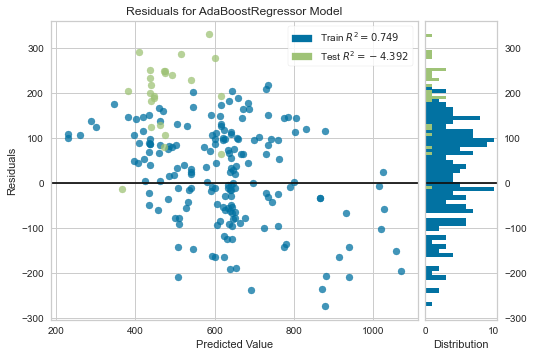

In [ ]:
# PLot model - Residual plot
plot_model(tuned_model)

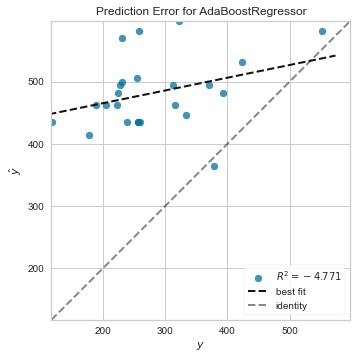

In [ ]:
# Prediction Error Plot
plot_model(model, plot = 'error')

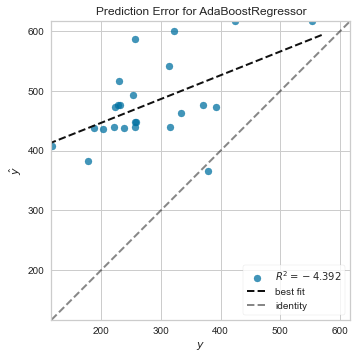

In [ ]:
# Prediction Error Plot
plot_model(tuned_model, plot = 'error')

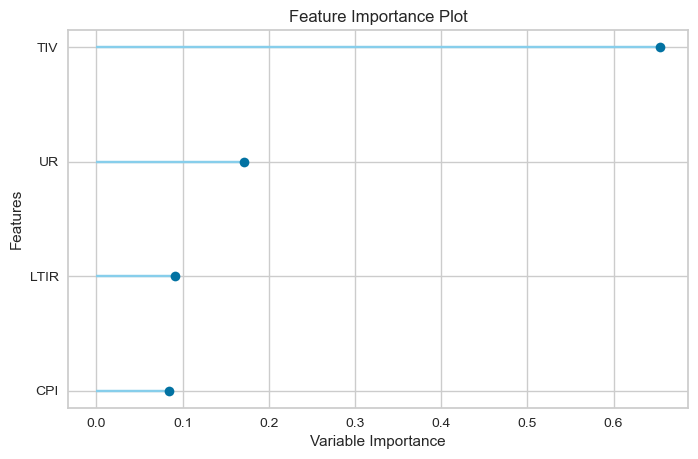

In [ ]:
# Feature Importance Plot
plot_model(model, plot='feature')

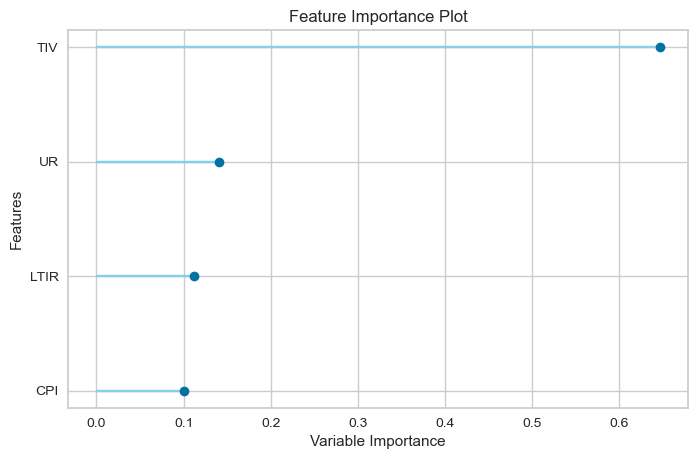

In [ ]:
# Feature Importance Plot
plot_model(tuned_model, plot='feature')

#### Evaluate models

In [ ]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### Predict on test set

In [ ]:
prediction = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,202.0847,48486.6368,220.1968,-4.7707,0.6556,0.8792


In [ ]:
prediction_tuned = predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,198.7312,45304.5714,212.8487,-4.3920,0.6340,0.8452


#### Predict full dataset

##### Base model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,102.9414,16103.0463,126.8978,0.6965,0.2979,0.2629


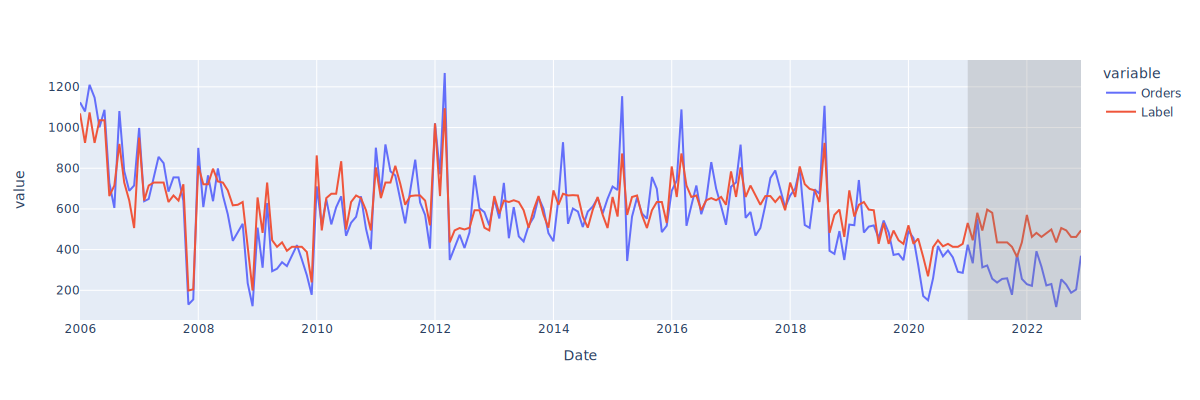

In [ ]:
# Generate predictions on the original dataset
predictions = predict_model(model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

##### Tuned model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,103.6053,15734.6244,125.4377,0.7035,0.2969,0.2643


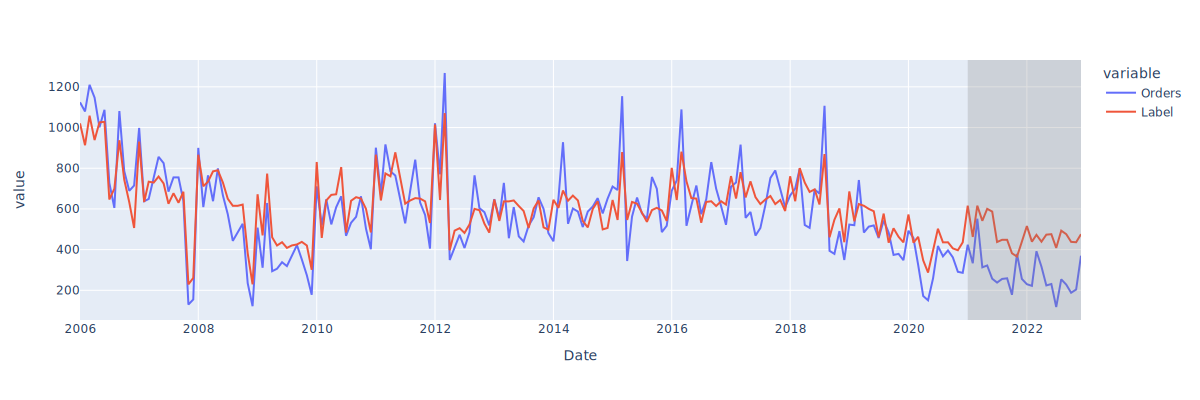

In [ ]:
# Generate predictions on the original dataset
predictions = predict_model(tuned_model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

#### Finalize model

In [ ]:
# Finalize the model i.e. train the best model on the entire dataset (this time, including the test set).
final = finalize_model(tuned_model)

In [ ]:
final

AdaBoostRegressor(base_estimator=None, learning_rate=0.2, loss='exponential',
                  n_estimators=160, random_state=42)